# 🔬 VQE Ground State Simulation of H₂ with Ansatz Comparison (Noiseless)

This notebook implements the **Variational Quantum Eigensolver (VQE)** to compute the **ground state energy of dihydrogen (H₂)** using a **noiseless quantum simulator**. It compares the performance of multiple **variational ansatzes** to understand their expressive power and convergence behavior.

### Key Features:
- **Molecular Setup**: Defines the H₂ molecule and constructs the qubit-based molecular Hamiltonian using the STO-3G basis.
- **Customizable Ansatz Selection**:
  - Uses a dictionary of predefined ansatzes (`ANSATZES`) including:
    - `TwoQubit-RY-CNOT` (toy 2-qubit entangler)
    - `Minimal` (simplified configuration)
    - `RY-CZ` (hardware-efficient style)
- **VQE Execution**:
  - Runs independent VQE loops for each ansatz using the **Adam optimizer**.
  - Tracks energy at each iteration for performance comparison.

### 📊 Visualization Outputs:
- **Energy convergence plots** for each ansatz over the training iterations.
- Final ground state energies per ansatz, enabling performance benchmarking.

### Purpose:
To evaluate and compare different **ansatz strategies** for variational quantum simulations, providing insight into trade-offs between expressivity, convergence speed, and implementation complexity in near-term quantum devices.

In [1]:
import pennylane as qml            # Quantum circuit builder and device management
from pennylane import numpy as np  # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem        # Quantum chemistry module used to define molecule Hamiltonians
import matplotlib.pyplot as plt
import sys, os, json, time
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from vqe.vqe_utils import get_optimizer, init_params, set_seed, make_run_config_dict, run_signature, find_existing_run, save_run_record, ensure_dirs, build_run_filename
from vqe.vqe_utils import IMG_DIR, ANSATZES

# Create folders if needed
ensure_dirs()

# Reproducible runs
seed = 0
set_seed(seed)

# Define the atoms in the dihydrogen molecule
symbols = ["H", "H"]

# Define the coordinates (in Ångströms)
coordinates = np.array([
    [0.0000, 0.0000, 0.0000],  # Hydrogen 1
    [0.0000, 0.0000, 0.7414]   # Hydrogen 2
])

# Define the dihydrogen Hamiltonian and the number of qubits required
basis = "STO-3G"
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0, basis=basis)

# Define the number of required quantum wires / logical qubits
num_wires = qubits
print(f"{qubits} qubits required")


4 qubits required


In [2]:
# Create noiseless quantum device simulator backend
dev = qml.device("default.qubit", wires=num_wires)

def create_cost(ansatz_fn):
    @qml.qnode(dev)
    def circuit(params):
        ansatz_fn(params, wires=[0, 1])
        return qml.expval(hamiltonian)
    return circuit

def run_ansatz_with_cache(ansatz_name, stepsize, max_iters):
    ansatz_fn = ANSATZES[ansatz_name]
    cost = create_cost(ansatz_fn)

    ansatz_desc = f"ansatz:{ansatz_name} (custom)"
    optimizer_name = "Adam"
    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iters,
        seed=seed,
    )

    # Canonical file name: readable prefix and signature
    sig = run_signature(cfg)
    fname = build_run_filename(f"H2_Ansatz_{ansatz_name}", optimizer_name, seed, sig)
    existing = find_existing_run(sig)

    if existing:
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] {ansatz_name}: loaded {existing}")
        energy_traj = rec["energies"]
        final_energy = float(energy_traj[-1])
        if "final_params" in rec:
            params = np.array(rec["final_params"], requires_grad=True)
        elif "params_by_step" in rec and rec["params_by_step"]:
            params = np.array(rec["params_by_step"][-1], requires_grad=True)
        else:
            params = init_params(ansatz_name, num_wires=2, scale=0.01, requires_grad=True)
        return final_energy, energy_traj, params

    # Compute results if this configuration has NOT been ran before
    params = init_params(ansatz_name, num_wires=2, scale=0.01, requires_grad=True)
    opt = get_optimizer(optimizer_name, stepsize=stepsize)
    energy_traj = []
    for _ in range(max_iters):
        params = opt.step(cost, params)
        energy_traj.append(float(cost(params)))
    final_energy = float(energy_traj[-1])

    run_record = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "molecule": "H2",
        "symbols": symbols,
        "geometry": coordinates.tolist(),
        "basis": basis,
        "num_wires": num_wires,
        "ansatz": ansatz_desc,
        "optimizer": {
            "name": optimizer_name,
            "stepsize": stepsize,
            "iterations_planned": max_iters,
            "iterations_ran": len(energy_traj),
        },
        "seed": seed,
        "energies": energy_traj,
        "final_params": [float(x) for x in params],
        "config_hash": sig,
    }

    persisted = save_run_record(fname, run_record)
    print(f"\n[saved] {ansatz_name}: {fname}")
    print(f"[mirrored] {persisted}")

    return final_energy, energy_traj, params

results = {}
max_iters = 80
stepsize = 0.2

for name in ANSATZES:
    print(f"\nRunning VQE with {name} Ansatz...")
    E, traj, params = run_ansatz_with_cache(name, stepsize=stepsize, max_iters=max_iters)
    results[name] = {"final_energy": E, "trajectory": traj, "params": params}
    print(f"Final energy for {name}: {E:.8f} Ha")


Running VQE with TwoQubit-RY-CNOT Ansatz...
[reuse] TwoQubit-RY-CNOT: loaded /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H2_Ansatz_TwoQubit-RY-CNOT_Adam_s0__6c64bc828f3a.json
Final energy for TwoQubit-RY-CNOT: -0.88770766 Ha

Running VQE with RY-CZ Ansatz...
[reuse] RY-CZ: loaded /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H2_Ansatz_RY-CZ_Adam_s0__60b54691cb50.json
Final energy for RY-CZ: -0.88769420 Ha

Running VQE with Minimal Ansatz...
[reuse] Minimal: loaded /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H2_Ansatz_Minimal_Adam_s0__52c322eb31d2.json
Final energy for Minimal: -0.88810382 Ha


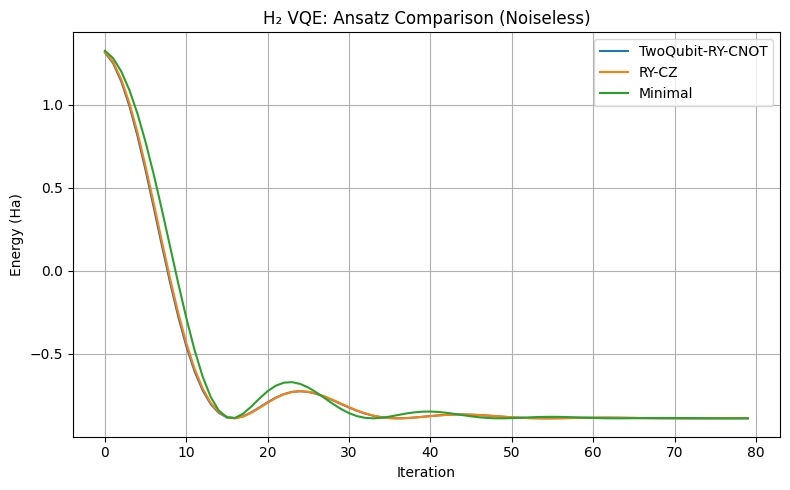

In [3]:
# Plot ansatz comparison
plt.figure(figsize=(8, 5))
for name, data in results.items():
    plt.plot(data["trajectory"], label=name)
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₂ VQE: Ansatz Comparison (Noiseless)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Ansatz_Comparison.png", dpi=300)
plt.show()


TwoQubit-RY-CNOT Ansatz Circuit for H₂:


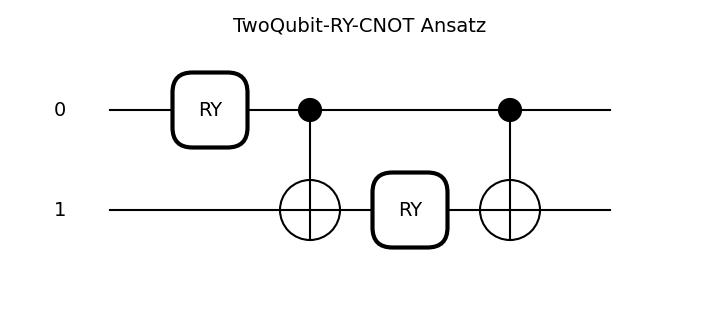


RY-CZ Ansatz Circuit for H₂:


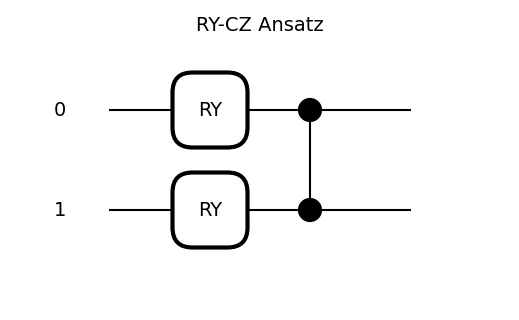


Minimal Ansatz Circuit for H₂:


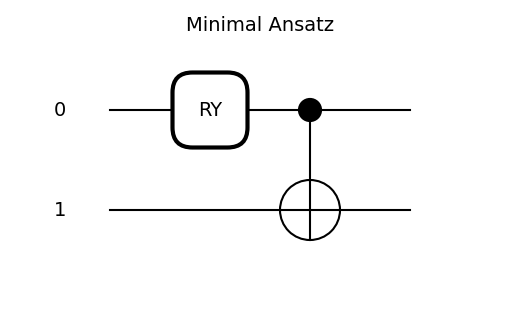

In [4]:
# Circuit diagrams
for name, ansatz_fn in ANSATZES.items():
    print(f"\n{name} Ansatz Circuit for H₂:")
    params = results[name]["params"]
    fig, ax = qml.draw_mpl(ansatz_fn)(params, wires=[0, 1])
    fig.suptitle(f"{name} Ansatz", fontsize=14)
    fig.savefig(f"{IMG_DIR}/H2_{name}_Circuit.png", dpi=300, bbox_inches="tight")
    plt.show()